2025-11-11 09:34:16.823848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762853657.041116      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762853657.107357      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-11 09:34:30.641049: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.1536 - loss: 2.9071 - val_accuracy: 0.5341 - val_loss: 1.7123
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5427 - loss: 1.5827 - val_accuracy: 0.7727 - val_loss: 0.9176
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7035 - loss: 0.9842 - val_accuracy: 0.8125 - val_loss: 0.6270
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7984 - loss: 0.6847 - val_accuracy: 0.8864 - val_loss: 0.4271
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8190 - loss: 0.5606 - val_accuracy: 0.9375 - val_loss: 0.3281
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8691 - loss: 0.4335 - val_accuracy: 0.9148 - val_loss: 0.3075
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8536 - loss: 0.4069 - val_accuracy: 0.9403 - val_loss: 0.2373
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9117 - loss: 0.3121 - val_accuracy: 0.9545 - 

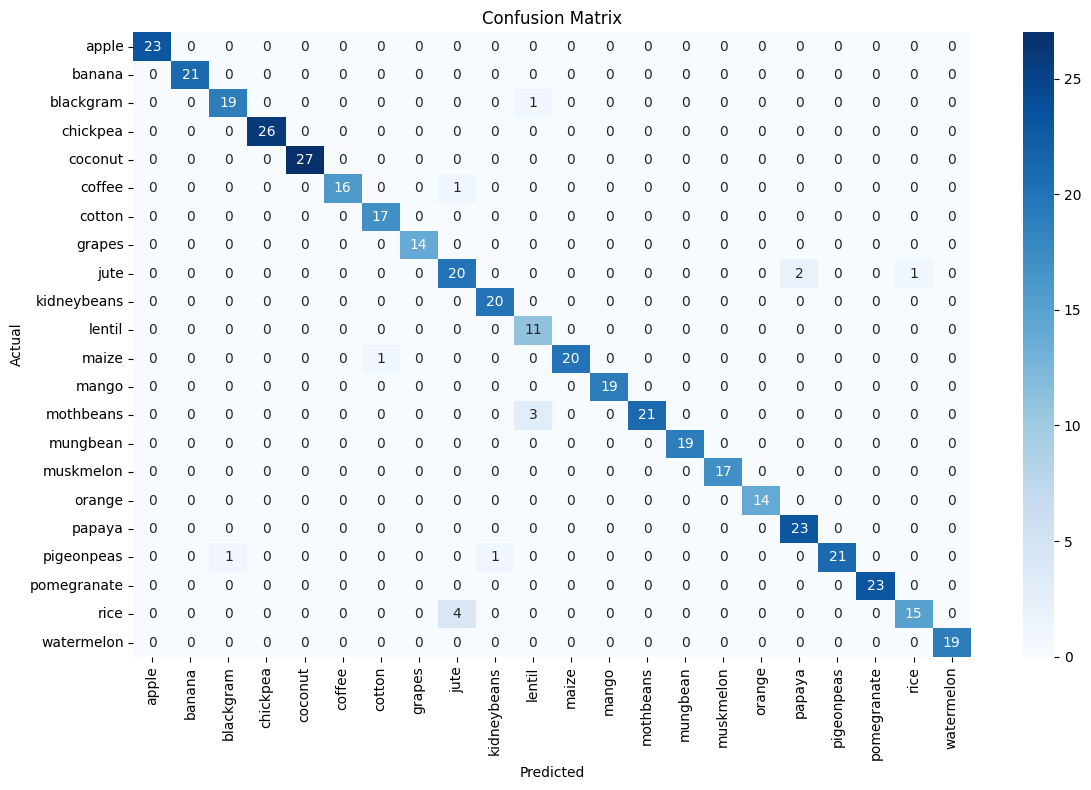

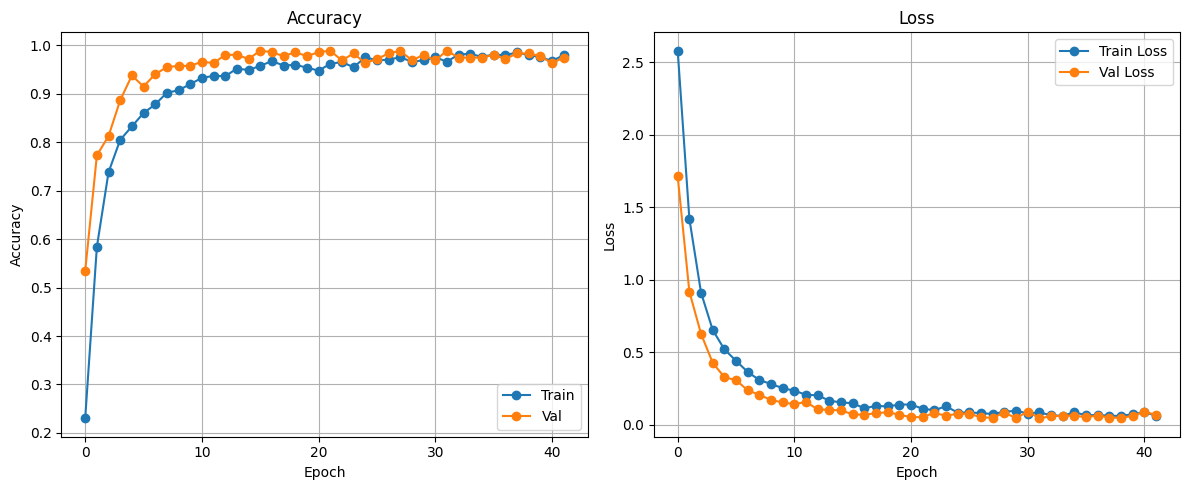

✅ Model saved as Crosstransformer_crop_recommendation.h5


In [1]:
import pandas as pd
import numpy as np
import shap
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Conv1D, GRU, LSTM, Dropout, MultiHeadAttention, LayerNormalization, Add, GlobalAveragePooling1D
from keras.layers import Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load and preprocess
df = pd.read_csv('/kaggle/input/crop-recommendation-dataset/Crop_recommendation.csv')
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
X = df[features].values
y = df['label'].values

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_seq = X_scaled.reshape((X_scaled.shape[0], 7, 1))  # (samples, features, 1)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_cat, test_size=0.2, random_state=42)

# CrossTransformer: Cross-attention from learnable query to features
def crosstransformer(input_dim, num_features, num_classes, d_model=32, num_heads=4, ff_dim=64):
    inp = Input(shape=(num_features,))

    # Linear projection of features
    x = Dense(d_model)(inp)  # Shape: (batch, d_model)
    x = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)

    # Keys/values = projected feature embeddings
    kv = Dense(d_model)(inp)  # (batch, d_model)
    kv = Lambda(lambda x: tf.expand_dims(x, axis=1))(kv)
    # Cross-attention (query attends to features)
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, kv)
    x = Add()([x, attn])
    x = LayerNormalization()(x)

    ff = Dense(ff_dim, activation='relu')(x)
    ff = Dense(d_model)(ff)
    x = Add()([x, ff])
    x = LayerNormalization()(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=inp, outputs=out)

model = crosstransformer(input_dim=7, num_features=7, num_classes=y_cat.shape[1])  # or crosstransformer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stop], verbose=1)

loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {acc:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# 5. Confusion Matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# 6. Accuracy & Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train', marker='o')
plt.plot(history.history['val_accuracy'], label='Val', marker='o')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Save model
model.save("Crosstransformer_crop_recommendation.h5")
print("✅ Model saved as Crosstransformer_crop_recommendation.h5")
